In [33]:
#generation debugging 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader
import networkx as nx
import rdkit
import math, random, sys
import numpy as np
import argparse
import os
from tqdm.auto import tqdm
import pickle
from hgraph import *
from hgraph.inc_graph import *
from hgraph.encoder import *
import matplotlib.pyplot as plt

In [2]:
vocab = '/home/marcase/hgraph2graph/data/chembl/cyclic_vocab_new.txt'
vocab = [x.strip("\r\n ").split() for x in open(vocab)]
vocab = PairVocab(vocab)

In [11]:
class Args:
    train = 'cyclic_preprocessed_new/'
    vocab = vocab
    save_dir = 'test/'
    atom_vocab = common_atom_vocab
    load_model = None
    seed = 7
    rnn_type = 'LSTM'
    hidden_size=125
    embed_size=250
    batch_size=1
    latent_size=32
    depthT=15
    depthG=15
    diterT=1
    diterG=3
    dropout=0.0
    lr = 1e-3
    clip_norm=5.0
    step_beta=0.001
    max_beta=1.0
    warmup=10000
    kl_anneal_iter=2000
    epoch=20
    anneal_rate=0.9
    anneal_iter=25000
    print_iter=50
    save_iter=5000
    
args=Args()

model = HierVAE(args).cuda()

In [12]:
print("Model #Params: %dK" % (sum([x.nelement() for x in model.parameters()]) / 1000,))
model

Model #Params: 1353K


HierVAE(
  (encoder): HierMPNEncoder(
    (E_c): Sequential(
      (0): Embedding(23, 250)
      (1): Dropout(p=0.0, inplace=False)
    )
    (E_i): Sequential(
      (0): Embedding(28, 250)
      (1): Dropout(p=0.0, inplace=False)
    )
    (W_c): Sequential(
      (0): Linear(in_features=375, out_features=125, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (W_i): Sequential(
      (0): Linear(in_features=375, out_features=125, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (W_root): Sequential(
      (0): Linear(in_features=250, out_features=125, bias=True)
      (1): Tanh()
    )
    (tree_encoder): MPNEncoder(
      (W_o): Sequential(
        (0): Linear(in_features=250, out_features=125, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.0, inplace=False)
      )
      (rnn): LSTM(
        (W_i): Sequential(
          (0): Linear(in_features=300, out_features=125, bias=True)
          (1): Sigmoid()
        )
 

In [13]:
for param in model.parameters():
    if param.dim() == 1:
        nn.init.constant_(param, 0)
    else:
        nn.init.xavier_normal_(param)
optimizer = optim.Adam(model.parameters(), lr=args.lr)
scheduler = lr_scheduler.ExponentialLR(optimizer, args.anneal_rate)

if args.load_model:
    print('continuing from checkpoint ' + args.load_model)
    model_state, optimizer_state, total_step, beta = torch.load(args.load_model)
    model.load_state_dict(model_state)
    optimizer.load_state_dict(optimizer_state)
else:
    total_step = beta = 0
param_norm = lambda m: math.sqrt(sum([p.norm().item() ** 2 for p in m.parameters()]))
grad_norm = lambda m: math.sqrt(sum([p.grad.norm().item() ** 2 for p in m.parameters() if p.grad is not None]))
meters = np.zeros(6)


In [14]:
epoch = range(args.epoch)[0]
dataset = DataFolder(args.train,args.batch_size)


In [15]:
# #begin training the model
# for batch in tqdm(dataset):
#     total_step += 1
#     model.zero_grad()
#     loss, kl_div, wacc, iacc, tacc, sacc = model(*batch, beta=beta)

In [16]:
data_file0 = os.path.join(dataset.data_folder,'tensors-0.pkl')
with open(data_file0,'rb') as f:
    batches = pickle.load(f)

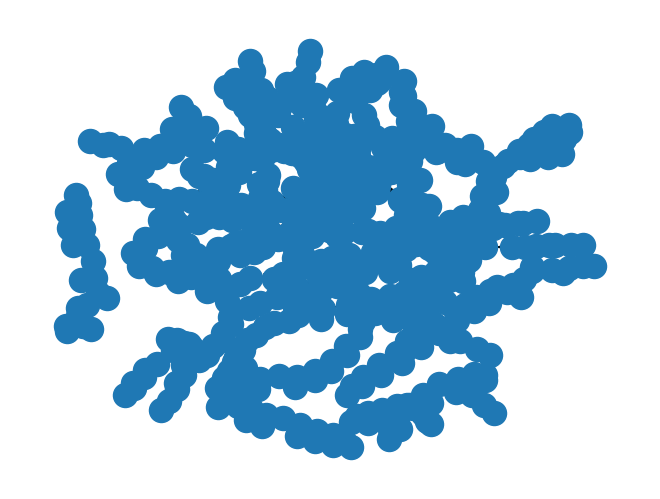

In [19]:
nx.draw(batches[0][0][0])
plt.show()

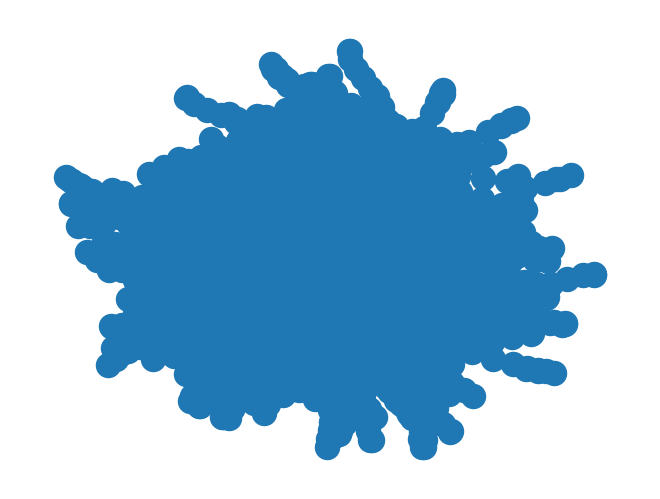

In [20]:
nx.draw(batches[0][0][1])
plt.show()

#just realized I have no idea what format the tensorized molecules are in. let's go back and check the tensorize function

In [20]:
#from model.sample()
batch_size = args.batch_size
latent_size = args.latent_size
root_vecs = torch.randn(batch_size, latent_size).cuda()

In [23]:
#from HierMPNDecoder.decode()
src_root_vecs, src_tree_vecs, src_graph_vecs = root_vecs,root_vecs,root_vecs
batch_size = len(src_root_vecs)
batch_size

1

(100, 2)


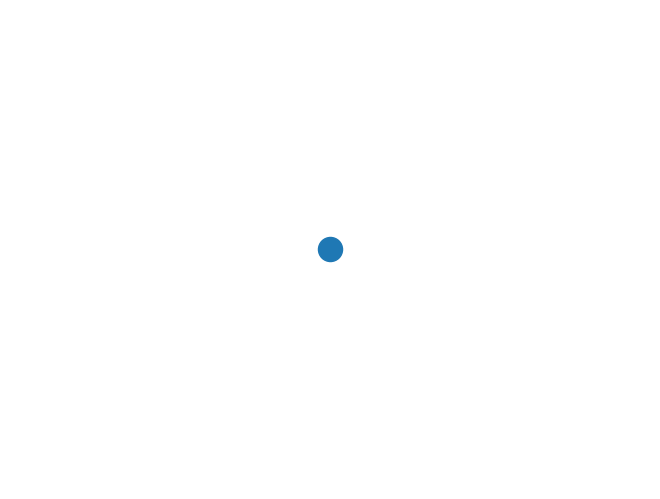

In [31]:
tree_batch = IncTree(batch_size, node_fdim=2, edge_fdim=3)
nx.draw(tree_batch.graph)

In [42]:
hmpn = IncHierMPNEncoder(args.vocab, args.atom_vocab, args.rnn_type, args.embed_size, args.hidden_size, args.depthT, args.depthG, args.dropout)
hmpn

IncHierMPNEncoder(
  (E_c): Sequential(
    (0): Embedding(23, 250)
    (1): Dropout(p=0.0, inplace=False)
  )
  (E_i): Sequential(
    (0): Embedding(28, 250)
    (1): Dropout(p=0.0, inplace=False)
  )
  (W_c): Sequential(
    (0): Linear(in_features=375, out_features=125, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
  )
  (W_i): Sequential(
    (0): Linear(in_features=375, out_features=125, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
  )
  (tree_encoder): IncMPNEncoder(
    (W_o): Sequential(
      (0): Linear(in_features=250, out_features=125, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (rnn): LSTM(
      (W_i): Sequential(
        (0): Linear(in_features=300, out_features=125, bias=True)
        (1): Sigmoid()
      )
      (W_o): Sequential(
        (0): Linear(in_features=300, out_features=125, bias=True)
        (1): Sigmoid()
      )
      (W_f): Sequential(
        (0): Linear(in_features=300, out_f

(100, 38)


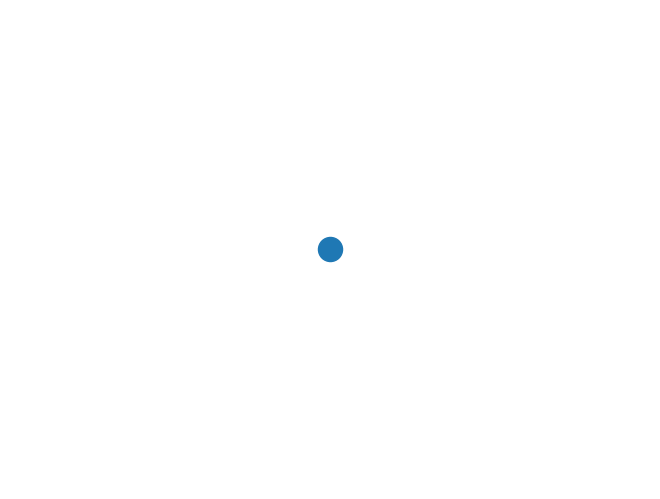

In [48]:
graph_batch = IncGraph(args.atom_vocab, batch_size, node_fdim=hmpn.atom_size, edge_fdim=hmpn.atom_size + hmpn.bond_size)
nx.draw(graph_batch.graph)

In [80]:
def get_cls_score(src_tree_vecs, batch_idx, cls_vecs, cls_labs):
    use_attention = False
    if use_attention:
        cls_cxt = self.attention(src_tree_vecs, batch_idx, cls_vecs, self.A_cls)
    else:
        cls_cxt = src_tree_vecs.index_select(index=batch_idx, dim=0).cuda()

    cls_vecs = torch.cat([cls_vecs, cls_cxt], dim=-1).cuda()
    clsNN = nn.Sequential(
                nn.Linear(args.hidden_size + args.latent_size, args.hidden_size),
                nn.ReLU(),
                nn.Dropout(args.dropout),
                nn.Linear(args.hidden_size, args.vocab.size()[0])
        ).cuda()
    iclsNN = nn.Sequential(
                nn.Linear(args.hidden_size + args.latent_size, args.hidden_size),
                nn.ReLU(),
                nn.Dropout(args.dropout),
                nn.Linear(args.hidden_size, args.vocab.size()[1])
        ).cuda()
    cls_scores = clsNN(cls_vecs)

    if cls_labs is None: #inference mode
        icls_scores = iclsNN(cls_vecs) #no masking
    else:
        vocab_masks = args.vocab.get_mask(cls_labs)
        icls_scores = iclsNN(cls_vecs) + vocab_masks #apply mask by log(x + mask): mask=0 or -INF
    return cls_scores, icls_scores

In [96]:
stack = [[] for i in range(batch_size)]
W_root = nn.Linear(args.latent_size, args.hidden_size).cuda()
init_vecs = src_root_vecs if args.latent_size == args.hidden_size else W_root(src_root_vecs)
itensor = torch.LongTensor([]).cuda()
batch_idx = itensor.new_tensor(range(batch_size))
cls_scores, icls_scores = get_cls_score(src_tree_vecs, batch_idx, init_vecs, None)
root_cls = cls_scores.max(dim=-1)[1]
icls_scores = icls_scores + args.vocab.get_mask(root_cls)
root_cls, root_icls = root_cls.tolist(), icls_scores.max(dim=-1)[1].tolist()

In [103]:
super_root = tree_batch.add_node() 
for bid in range(batch_size):
    clab, ilab = root_cls[bid], root_icls[bid]
    root_idx = tree_batch.add_node( batch_idx.new_tensor([clab, ilab]) )
    tree_batch.add_edge(super_root, root_idx) 
    stack[bid].append(root_idx)

    root_smiles = args.vocab.get_ismiles(ilab)
    new_atoms, new_bonds, attached = graph_batch.add_mol(bid, root_smiles, [], 0)
    tree_batch.register_cgraph(root_idx, new_atoms, new_bonds, attached)

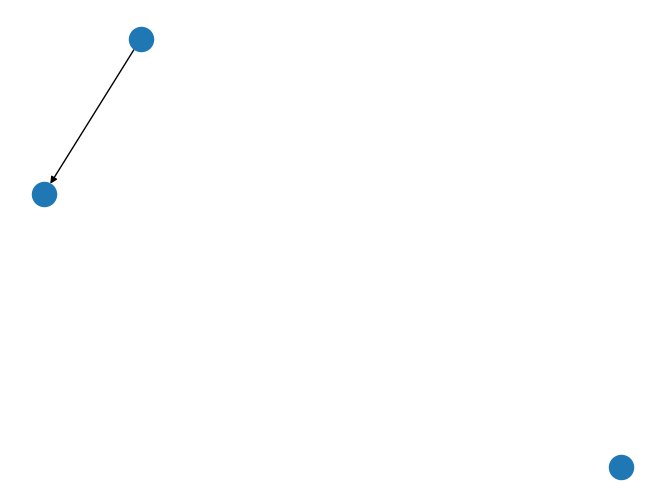

In [110]:
nx.draw(tree_batch.graph)

In [144]:
class HTuple():
    def __init__(self, node=None, mess=None, vmask=None, emask=None):
        self.node, self.mess = node, mess
        self.vmask, self.emask = vmask, emask
#invariance: tree_tensors is equal to inter_tensors (but inter_tensor's init_vec is 0)
tree_tensors = tree_batch.get_tensors()
graph_tensors = graph_batch.get_tensors()

htree = HTuple( mess = hmpn.tree_encoder.rnn.get_init_state(tree_tensors[1]) )
hinter = HTuple( mess = hmpn.tree_encoder.rnn.get_init_state(tree_tensors[1]) )
hgraph = HTuple( mess = hmpn.tree_encoder.rnn.get_init_state(graph_tensors[1]) )
h = hmpn.tree_encoder.rnn.get_hidden_state(htree.mess)
h[1 : batch_size + 1] = init_vecs #wiring root (only for tree, not inter)

In [199]:
tree_batch.get_cluster_edges(cur_tree_nodes)

[1, 2, 3, 4]

In [192]:
#decode one step at a time
t=0 #up to max_decode_step, which is 100 by default
batch_list = [ bid for bid in range(batch_size) if len(stack[bid]) > 0 ]

In [193]:
batch_idx = batch_idx.new_tensor(batch_list)
cur_tree_nodes = [stack[bid][-1] for bid in batch_list]
subtree = batch_idx.new_tensor(cur_tree_nodes).cuda(), batch_idx.new_tensor([]).cuda()
subgraph = batch_idx.new_tensor( tree_batch.get_cluster_nodes(cur_tree_nodes) ).cuda(), batch_idx.new_tensor( tree_batch.get_cluster_edges(cur_tree_nodes) ).cuda()

In [162]:
htree, hinter, hgraph = hmpn(tree_tensors, tree_tensors, graph_tensors, htree, hinter, hgraph, subtree, subgraph)
def get_topo_score(self, src_tree_vecs, batch_idx, topo_vecs):
    use_attention = False
    if use_attention:
        topo_cxt = self.attention(src_tree_vecs, batch_idx, topo_vecs, self.A_topo)
    else:
        topo_cxt = src_tree_vecs.index_select(index=batch_idx, dim=0)
    return self.topoNN( torch.cat([topo_vecs, topo_cxt], dim=-1) ).squeeze(-1)
topo_scores = get_topo_score(src_tree_vecs, batch_idx, htree.node.index_select(0, subtree[0]))
topo_scores = torch.sigmoid(topo_scores)
if greedy:
    topo_preds = topo_scores.tolist()
else:
    topo_preds = torch.bernoulli(topo_scores).tolist()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_addmm)

In [190]:
hinter.node